In [1]:
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Activation, Input
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import  EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from tensorflow.keras.layers import Dropout
from keras import backend as K 
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from random import randint, random

from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [2]:
image_size = (208,208)
batch_size = 32

In [3]:
def correct_data_car(image_size):
    a,b = image_size
    boxes = []
    car_class = []
    df = pd.read_csv('_annotations.csv') 
    for x1,y1,x2,y2 in zip(df['xmin'].apply(lambda x: int(x) / 416 * a), list(df['ymin'].apply(lambda x: int(x) / 416 * b)), 
                       list(df['xmax'].apply(lambda x: int(x) / 416 * a)), list(df['ymax'].apply(lambda x: int(x) / 416 * b))):
        arr = [int(x1), int(y1), int(x2), int(y2)]
        boxes.append(arr)
    return df, boxes

In [4]:
def correct_data_accidents(image_size):
    boxes = []
    a,b = image_size
    df = pd.read_csv('accidents.csv') 
    for x1,y1,x2,y2 in zip(list(df['xmin'].apply(lambda x: int(x) * (a / 1280))), list(df['ymin'].apply(lambda x: int(x) * (b / 720))), 
                           list(df['xmax'].apply(lambda x: int(x) * (a / 1280))), list(df['ymax'].apply(lambda x: int(x) * (b / 720)))):
        arr = [int(x1), int(y1), int(x2), int(y2)]
        boxes.append(arr)
    return df, boxes

In [5]:
def data_metrics(df,image_size):
    images = []
    
    for index, i in df.iterrows():
        image = cv2.imread(index)
        image = cv2.resize(image,image_size)
        images.append(image)
    return images

In [6]:
def classification(df):
    train_class = []
    for index, row in df.iterrows():
        if row['class'] == 'vehicle' or row['class'] == 'motorbike':
            train_class.append([0,1])
        elif row['class'] =='accidents':
            train_class.append([1,0])
        else: 
            train_class.append([0,0])
    return train_class

In [7]:
def data_img(images, coordinates, image_size):
    scarled_region_class = []
    scarled_region_loc = []
    a,b = image_size
    for image, coords in zip(images, coordinates):
        x, y, w, h = coords
        car_region = image[y:h, x:w]
        scarled_region_class.append(cv2.resize(car_region, image_size))
        #scarled_region_class.append(cv2.resize(image[y:h-y,x:w-x], image_size))
        scarled_region_loc.append(cv2.resize(image, image_size))
#         else:
#             scarled_region_class.append(cv2.resize(image, image_size))
#             scarled_region_loc.append(cv2.resize(image, image_size))
    return np.array(scarled_region_loc), np.array(coordinates),np.array(scarled_region_class)#, np.array(region)
        
    

In [8]:
def rec_data(images):
    boxes = []
    for image in images:
        boxes.append([randint(0,10),randint(0,10),randint(190,208),randint(190,208)])
    return np.array(boxes)

In [9]:
def data_test_fun(images, coordinates, image_size):
    scaled_regions = []
    labels = []
    for image, coords in zip(images, coordinates):
        x, y, w, h = coords
        if x + y + w + h != -4:
            scaled_region = cv2.resize(image, image_size)
            scaled_regions.append(scaled_region)
        else:
            #image = np.array(image)
            scaled_regions.append(cv2.resize(image, image_size))
    return np.array(scaled_regions), np.array(coordinates)

In [10]:
def _data_car(df,image_size):
    boxes = []
    a,b = image_size
    for height, width, x1, y1, x2, y2 in zip(df['height'], df['width'], list(df['xmin'].apply(lambda x: int(x) / 416 * a)), list(df['ymin'].apply(lambda x: int(x) / 416 * a)), 
               list(df['xmax'].apply(lambda x: int(x) / 416 * a)), list(df['ymax'].apply(lambda x: int(x) / 416 * a))):
        if height == 0 and width ==0:
            boxes.append([0,0,0,0])
        else:
            arr = [int(x1), int(y1), int(x2), int(y2)]
            boxes.append(arr)
    return boxes

In [11]:
def _data_acc(df,image_size):
    boxes = []
    a,b = image_size
    for x1,y1,x2,y2 in zip(list(df['xmin'].apply(lambda x: int(x) * (a / 1280))), list(df['ymin'].apply(lambda x: int(x) * (b / 720))), 
                           list(df['xmax'].apply(lambda x: int(x) * (a / 1280))), list(df['ymax'].apply(lambda x: int(x) * (b / 720)))):
        arr = [int(x1), int(y1), int(x2), int(y2)]
        boxes.append(arr)
    return boxes

In [11]:
# df_trash = pd.DataFrame({'filename': os.listdir('DataSet_cars_valid\\1_trash')})
# df_trash = df_trash.set_index('filename')
# df_trash = df_trash.astype(str)

In [12]:
%cd data/train/Accident — копия
df_accidents, boxes_accidents = correct_data_accidents(image_size)
df_accidents = df_accidents.set_index('filename')
del df_accidents['Unnamed: 0']
df_accidents = df_accidents.astype(str)
boxes_accidents = _data_acc(df_accidents, image_size)
image_acc = data_metrics(df_accidents,image_size)
%cd ../../..

C:\Users\Matvey\Проект\Project\data\train\Accident — копия
C:\Users\Matvey\Проект\Project


In [13]:
%cd DataSet_cars_valid/valid_
df_car, boxes_car = correct_data_car(image_size)
df_car = df_car.set_index('filename')
#train = pd.concat([df_car, df_trash])
#train = train.fillna(0)
boxes_car = _data_car(df_car,image_size)
# train = train.sort_values(by = 'filename')
train = pd.concat([df_car,df_accidents])
# train = train.set_index('filename')
boxes_train = boxes_car + boxes_accidents
image_train = data_metrics(train,image_size)
%cd ../..

C:\Users\Matvey\Проект\Project\DataSet_cars_valid\valid_
C:\Users\Matvey\Проект\Project


In [14]:
region_train, image_coodrs, scarled_region = data_img(image_train, boxes_train, image_size)

In [81]:
boxes_region = rec_data(scarled_region)

In [16]:
boxes_train

[[19, 7, 207, 207],
 [14, 38, 197, 207],
 [6, 93, 190, 192],
 [45, 0, 151, 200],
 [13, 16, 25, 35],
 [4, 38, 196, 171],
 [5, 56, 206, 205],
 [16, 72, 192, 198],
 [13, 45, 199, 173],
 [16, 59, 152, 178],
 [27, 86, 193, 207],
 [8, 23, 202, 176],
 [18, 20, 195, 195],
 [7, 46, 199, 170],
 [28, 51, 169, 184],
 [17, 56, 195, 182],
 [11, 28, 186, 182],
 [21, 45, 192, 178],
 [33, 64, 181, 177],
 [5, 123, 204, 202],
 [12, 16, 190, 205],
 [4, 22, 203, 187],
 [34, 4, 207, 207],
 [6, 52, 201, 187],
 [16, 67, 191, 179],
 [2, 5, 204, 194],
 [23, 50, 185, 173],
 [6, 6, 202, 198],
 [90, 73, 191, 138],
 [1, 13, 201, 175],
 [18, 11, 147, 191],
 [42, 15, 157, 180],
 [3, 44, 206, 164],
 [2, 57, 205, 185],
 [9, 90, 203, 195],
 [15, 7, 199, 195],
 [21, 67, 154, 172],
 [1, 58, 207, 168],
 [4, 52, 206, 166],
 [3, 5, 203, 207],
 [2, 20, 207, 180],
 [16, 60, 191, 177],
 [5, 54, 192, 178],
 [11, 60, 198, 195],
 [19, 40, 185, 176],
 [4, 1, 207, 206],
 [44, 15, 159, 195],
 [8, 6, 198, 195],
 [99, 24, 110, 39],
 [7

In [17]:
for i, image in enumerate(region_train):
    if i % 100 == 0: print(i)
    x, y, w, h = image_coodrs[i]
    cv2.rectangle(image, (x, y), (w, h), (0, 255, 0), 2)
    cv2.imshow('Image', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

0


KeyboardInterrupt: 

In [39]:
class_train = classification(train)

In [19]:
#Загрузить модель NasNetMobile, обязательно исключив вершину для трансферного обучения
N_mobile = tf.keras.applications.NASNetMobile( input_tensor = Input(
    shape=(208,208,3)), 
    include_top=False, 
    weights='imagenet')

In [56]:
model = keras.Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(208, 208, 3)),  # свёрточный слой
    #попробуй по 2-3 свёрточных слоя сделать
    MaxPooling2D((2, 2), strides=2),  # уменьшение карт признаков
    Dropout(0.2),  # отключение 20 процентов нейронов

    Conv2D(128, (3, 3), activation='relu'),  # свёрточный слой
    MaxPooling2D((2, 2), strides=2),  # уменьшение карт признаков
    Dropout(0.2),  # отключение 20 процентов нейронов

    Conv2D(256, (3, 3), activation='relu'),  # свёрточный слой
    MaxPooling2D((2, 2), strides=2),  # уменьшение карт признаков
    Dropout(0.2),  # отключение 20 процентов нейронов

    Conv2D(256, (3, 3), activation='relu'),  # свёрточный слой
    MaxPooling2D((2, 2), strides=2),  # уменьшеи карт признаков
    Dropout(0.2),  # отключение 20 процентов нейронов

    Conv2D(512, (3, 3), activation='relu'),  # свёрточный слой
    MaxPooling2D((2, 2), strides=2),  # уменьшение карт признаков
    Dropout(0.2),  # отключение 20 процентов нейронов

    Flatten(),
    Dense(512, activation='relu'),  # обычные нейроны
    Dropout(0.2),  # отключение 20 процентов нейронов
    Dense(256, activation='relu'),  # обычные нейроны
    Dropout(0.2),  # отключение 20 процентов нейронов
    Dense(128, activation='relu'),  # обычные нейроны
    Dropout(0.2),  # отключение 20 процентов нейронов
    Dense(2, activation='sigmoid'),  # выходной слой
])

In [57]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
losses = { 
    "box_output": "mean_squared_error",
    "class_output": "categorical_crossentropy"
    }


loss_weights = {
    "box_output": 1.0, 
    "class_output": 1.0
    }


metrics = {
    'class_output': 'accuracy', 
    'box_output':  'mse'
    }

# Ранняя остановка, чтобы остановить модель, если суммарные потери val не снизятся на 0.001 за 40 эпох
stop = EarlyStopping(monitor = "val_loss", min_delta = 0.0001, patience = 40, 
                    restore_best_weights = True
                     )

#Изменение скорости обучения в зависимости от количества эпох для повышения эффективности обучения
reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.0002, 
                              patience = 30, min_lr = 1e-7, verbose = 1)
#оптимизация
opt = SGD(lr = 1e-3, momentum = 0.9)


model.compile(optimizer = opt, loss = losses, loss_weights = loss_weights, 
    metrics = metrics)

In [58]:
train_data, val_data, train_coords, val_coords,train_class, val_class, train_region, val_region = train_test_split(
    region_train, image_coodrs, class_train,scarled_region, test_size=0.2, random_state=42)

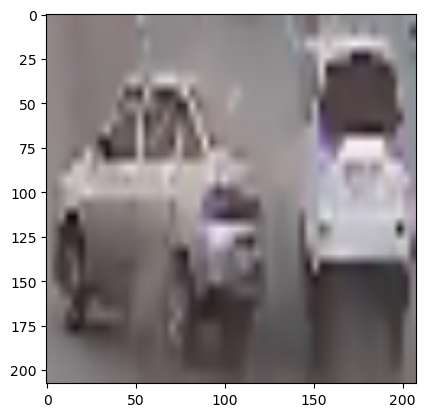

In [22]:
test = tf.convert_to_tensor(train_region[2])
plt.imshow(test, cmap='gray')
plt.show()

In [59]:
train_class = np.array(train_class)
val_class = np.array(val_class)

In [115]:
train_coords

array([[  5,   6, 201, 202],
       [  7,  51, 199, 188],
       [132,  63, 189,  93],
       ...,
       [ 10,  39, 188, 188],
       [ 17,  12, 200, 193],
       [  7,  10, 201, 195]])

In [60]:
history = model.fit(train_region, 
                    train_class,
                    validation_data=(
                        val_region, 
                        val_class 
                          ), batch_size = 32, epochs = 20, 
                    callbacks=[reduce_lr, stop])

Epoch 1/20
72/72 [==============================] - 10s 124ms/step - loss: 1.9045 - accuracy: 0.9031 - val_loss: 0.1403 - val_accuracy: 0.9140
Epoch 2/20


ResourceExhaustedError:  OOM when allocating tensor with shape[32,128,206,206] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/sequential_4/max_pooling2d_20/MaxPool/MaxPoolGrad (defined at \AppData\Local\Temp\ipykernel_6552\99737254.py:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_30917]

Function call stack:
train_function


In [37]:
history = model.fit(train_region, train_class, epochs = 60, batch_size = batch_size, validation_data = (val_region, val_class))

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type builtin_function_or_method).

In [55]:
model.save('class.h5')